In [1]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 20.4 MB/s eta 0:00:00


In [2]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.9 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.3/112.6 GB disk)


In [5]:
!unzip /content/ANPR_dataset.zip -d /content/yolo_dataset

Archive:  /content/ANPR_dataset.zip
  inflating: /content/yolo_dataset/README.dataset.txt  
  inflating: /content/yolo_dataset/README.roboflow.txt  
  inflating: /content/yolo_dataset/data.yaml  
  inflating: /content/yolo_dataset/test/images/11_jpg.rf.2602365ef3b564b008f0a59c37e7b419.jpg  
  inflating: /content/yolo_dataset/test/images/129_jpg.rf.c2ed17d996d22482687b6dcbdb36859e.jpg  
  inflating: /content/yolo_dataset/test/images/133_jpg.rf.64529976f8b4f0cd07464643365050a7.jpg  
  inflating: /content/yolo_dataset/test/images/151_jpg.rf.271c6a32fe47d09ffef270101fa07cd3.jpg  
  inflating: /content/yolo_dataset/test/images/15_jpg.rf.1e58dbdff67ab09373b717b8726badf1.jpg  
  inflating: /content/yolo_dataset/test/images/170_jpg.rf.307a4998e654e162ee6f66c4128cfc5d.jpg  
  inflating: /content/yolo_dataset/test/images/186_jpg.rf.48eb6b4c14223de8d4fb4e4a428d200b.jpg  
  inflating: /content/yolo_dataset/test/images/207_jpg.rf.a7e8bcf48a71591514cc4d082eb87e46.jpg  
  inflating: /content/yolo_dat

## Import YOLO

In [6]:
from ultralytics import YOLO

from IPython.display import display, Image

## Fine-tune the model to detect number plates of cars

In [7]:
!yolo task=detect mode=train data=/content/yolo_dataset/data.yaml model="yolo11n.pt" epochs=40 imgsz=640

100% 5.35M/5.35M [00:00<00:00, 109MB/s]
Ultralytics 8.3.9 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/yolo_dataset/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

## Inference on the fine-tuned model

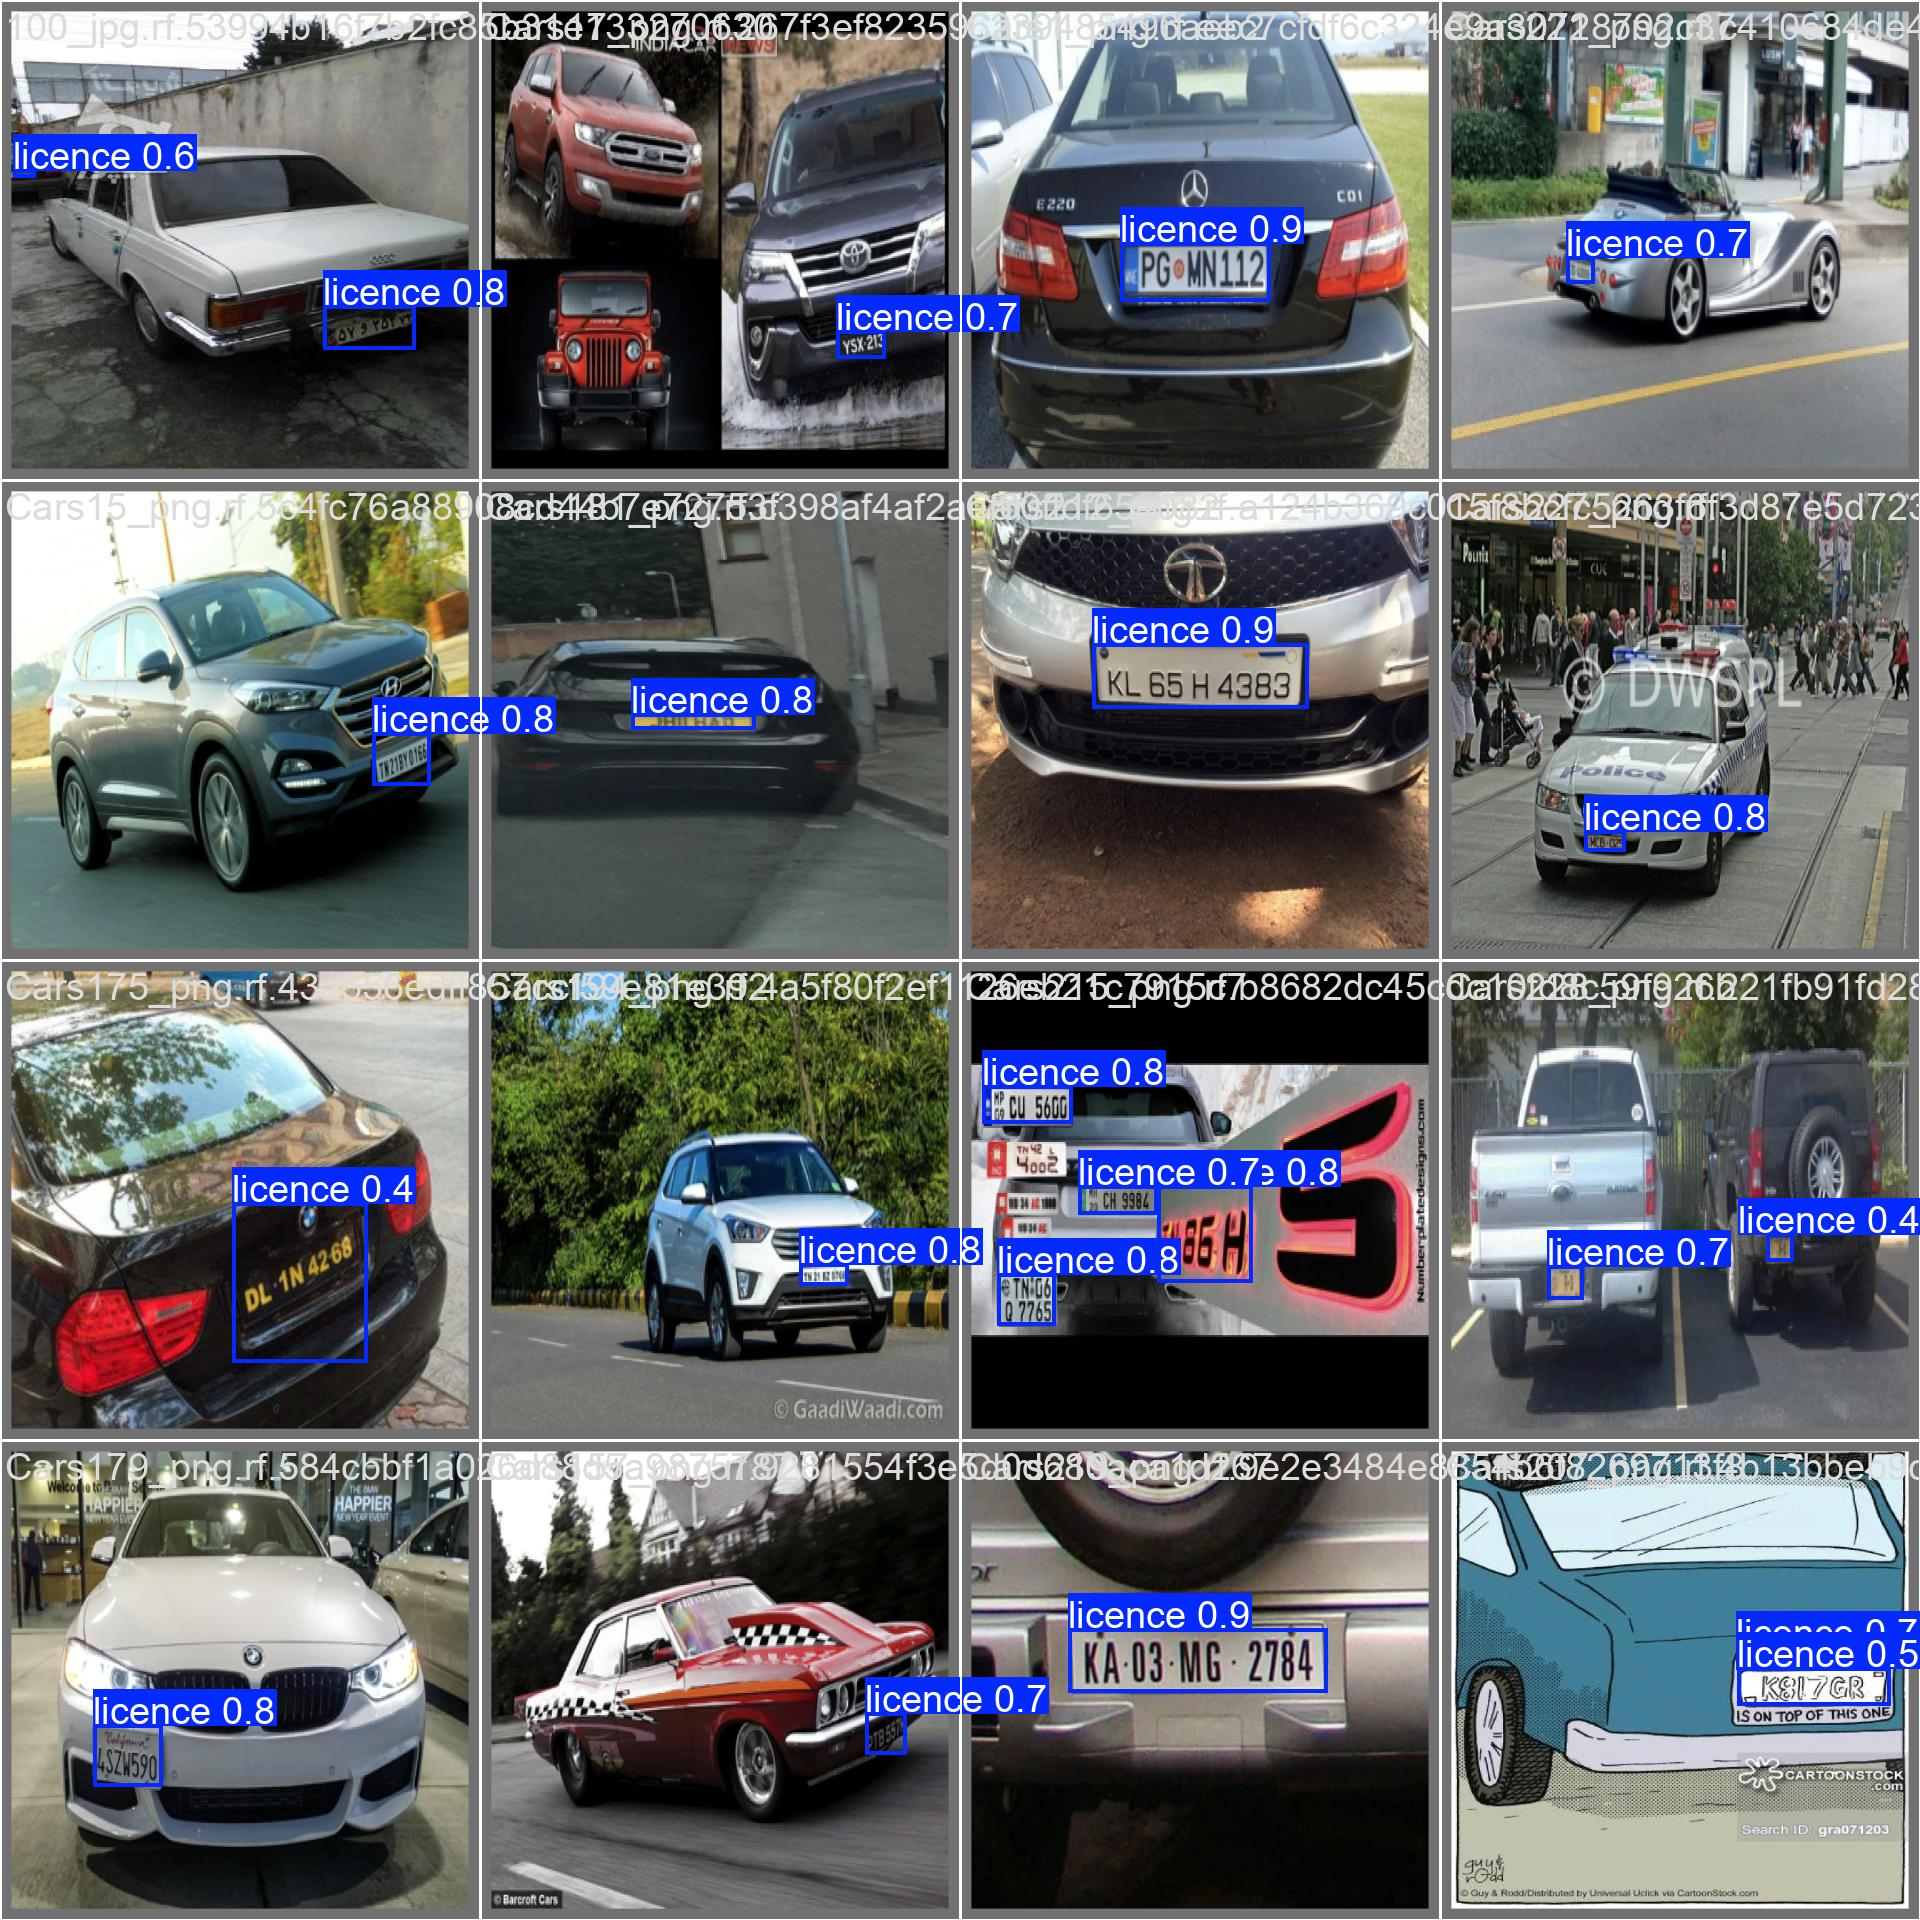

In [9]:
Image("/content/runs/detect/train/val_batch0_pred.jpg", width=600)

## Load the fine-tuned model

In [16]:
model=YOLO('/content/runs/detect/train/weights/best.pt')

In [195]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
image = cv2.imread('/content/yolo_dataset/valid/images/Cars150_png.rf.2a23b31e5a8a71250202ce7f14ae1ce5.jpg')

## Get the bounding box of the number plates detected


0: 640x640 1 licence, 18.7ms
Speed: 2.6ms preprocess, 18.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


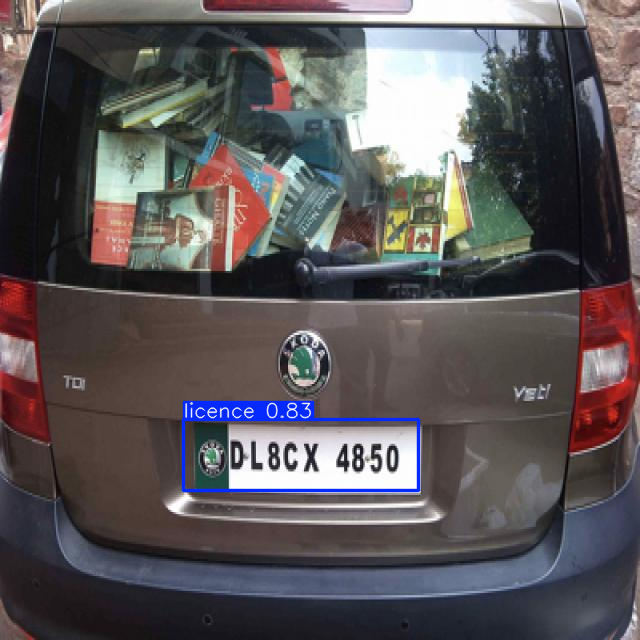

In [196]:
results=model.predict(image)
result=results[0]
result.show()

## Crop the image, apply pre-processing and extract text using easy-ocr

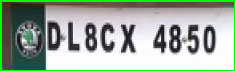

Detected License Plate Text: DLBCX 4850


In [197]:
import easyocr
for result in results:
    for box in result.boxes:
        # Coordinates of the bounding box
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

        # Draw the bounding box on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Crop the detected license plate area
        license_plate_img = image[y1:y2, x1:x2]

        # Show the cropped license plate

        gray_image = cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2GRAY)

        # Denoising
        denoised_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

        # Thresholding
        _, binary_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        cv2_imshow(license_plate_img)
        reader = easyocr.Reader(['en'])
        result = reader.readtext(license_plate_img)

        for (bbox, text, prob) in result:
            print(f"Detected License Plate Text: {text}")
